1. 统计工具
    * 自回归模型
    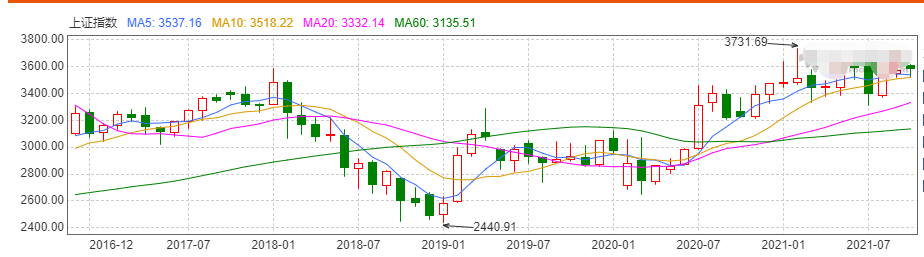
    隐变量自回归模型x^t=P(xt∣ht) ht=g(ht−1,xt−1)  
    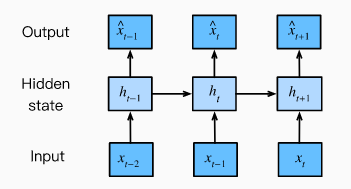
    序列估计值计算
    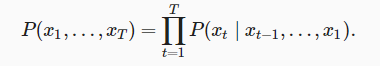
    * 马尔可夫模型
    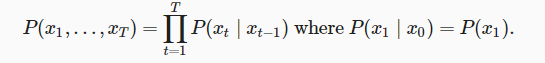
    利用动态规划高效计算
    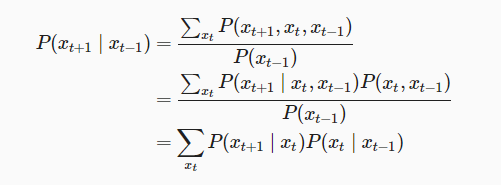
    * 因果关系
***
2. 训练
***
3. 预测:k -step-ahead-prediction
    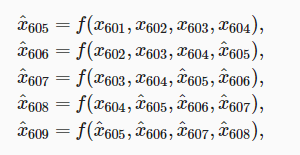
***
4. 小结

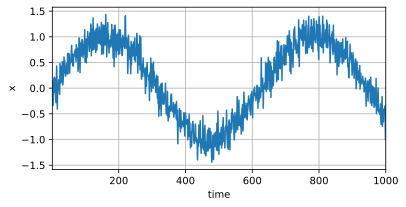

In [1]:
# 训练
%matplotlib inline
import torch
from torch import nn
import d2l as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=d2l.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


In [5]:
# 在这里，我们仅使用前600个
tau = 4
features = torch.zeros((T - tau, tau)) # 996X4
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [6]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失
loss = nn.MSELoss()

In [7]:
# 开始训练
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.055505
epoch 2, loss: 0.050858
epoch 3, loss: 0.049659
epoch 4, loss: 0.047903
epoch 5, loss: 0.049890


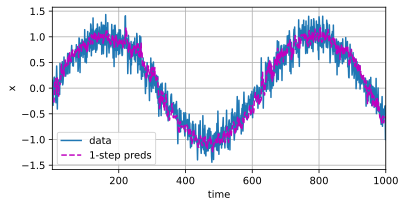

In [8]:
# 预测：
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

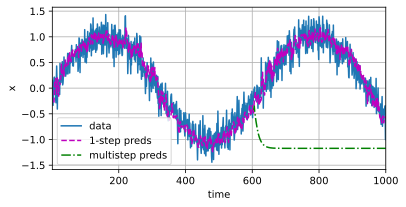

In [9]:
# 使用自己的预测（而不是原始数据）来进行多步预测。看看效果如何
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

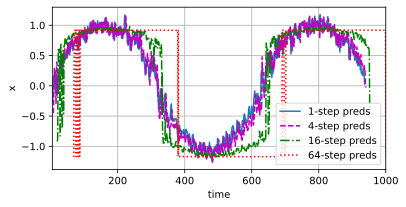

In [33]:
# 基于  k=1,4,16,64 ，通过对整个序列预测的计算，让我们更仔细地看一下 k 步预测的困难。
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

In [23]:

i=4
features[:, i] = x[i: i + T - tau - max_steps + 1]

In [32]:
steps = (1, 4, 16, 64)
[time[tau + i - 1: T - max_steps + i] for i in steps]

[tensor([  5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
          17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
          29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
          41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
          53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
          65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
          77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
          89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
         101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
         113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123., 124.,
         125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
         137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148.,
         149., 150., 151., 1